This document describes an attempt to solve for the gains of the first two loops of this block diagram to ensure that at a pair of the poles end up in a desired location.

![](http://moorepants.github.io/dissertation/_images/inner-loops.png)

where

$$G_{nm}(s) = \frac{\omega_{nm}^2}{s^2 + 2\zeta_{nm}\omega_{nm}s + \omega_{nm}^2}$$

and the bicycle block is the linearized Whipple model as presented in Meijaard 2007.

# Setup

In [1]:
import os
import dill
from IPython.display import display, Math
from sympy import MatrixSymbol, Eq, simplify, Poly, det, latex, S, solve, cse
from dtk import bicycle
import bicycleparameters as bp

The `roll_rate_loop.py` file builds the bicycle state space, the neuromuscular state space, and finally the state equations for the closed loop system when the steering angle and roll rate feedback loops are closed.

In [2]:
%run ../src/roll_rate_loop.py

# State Space Definitions

The bicycle state equations take this general form:

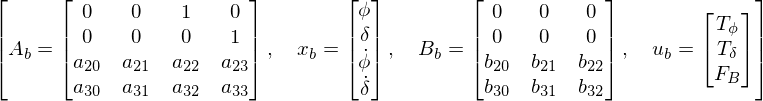

In [3]:
[Eq(MatrixSymbol('{}_b'.format(v), *b[v].shape), b[v]) for v in ['A', 'x', 'B', 'u']]

The second order neuromuscular model can be put in this state space form:

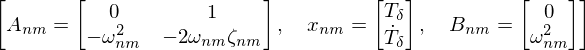

In [4]:
[Eq(MatrixSymbol('{}_nm'.format(v), *n[v].shape), n[v]) for v in ['A', 'x', 'B']]

The closed loop state equations for the first two loops that are closed around the combine neuromuscular and bicycle model then become:

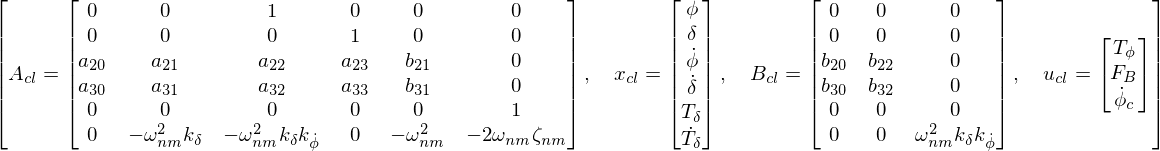

In [5]:
[Eq(MatrixSymbol('{}_cl'.format(v), *c_phidot[v].shape), c_phidot[v]) for v in ['A', 'x', 'B', 'u']]

# Characteristic Equation

The characteristic equation can be formed for this closed loop system and converted to a polynomial.

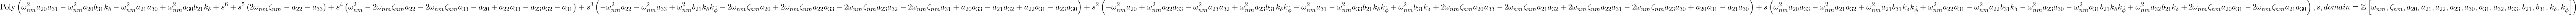

In [6]:
s = Symbol('s')
char_eq = det(c_phidot['A'] - s * eye(c_phidot['A'].shape[0])).as_poly(s)
char_eq

Additionally, the coefficients to the 6th order polynomial can be extracted and simplified:

In [7]:
for i, coeff in enumerate(char_eq.coeffs()):
    display(Math(r'$s^{}: {}$'.format(len(char_eq.coeffs()) - i - 1, latex(simplify(coeff)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The symbolic form of the characteristic equation *cannot* be easily factored.

In [8]:
char_eq.factor()

# Solve for the gains

There are two control gains, $k_\delta$ and $k_{\dot{\phi}}$, that are the unknowns. We'd like to find the value of the two gains such that the weave poles when there is no feedback, i.e. $k_\delta=0$ and $k_{\dot{\phi}}=0$, shift to a pair of poles when there is feedback that are located at a damping ratio of 0.15 and a natural frequency of 10 rad/s. This pair of poles gives a desired second order system:

In [9]:
omega_d, zeta_d = symbols('omega_d, zeta_d', real=True, positive=True)

In [10]:
desired_second_order = Poly((s**2 + 2 * zeta_d * omega_d * s + omega_d**2), s)
desired_second_order

This pair of poles must be accompanied by four more poles to equate to the sixth order system above. The desired sixth order system with arbitrary coefficients is then:

In [11]:
c0, c1, c2, c3 = symbols('c0, c1, c2, c3')
desired_six_order = Poly(s**4 + c3 * s**3 + c2 * s**2 + c1 * s + c0, s) * desired_second_order
desired_six_order

The coefficients of the desired polynomial and the one formed from the closed loop system can then be substracted from each other to solve for the unknowns: $c_0, c_1, c_2, c_3, k_\delta, k_{\dot{\phi}}$. This gives 6 equations for the six unknowns.

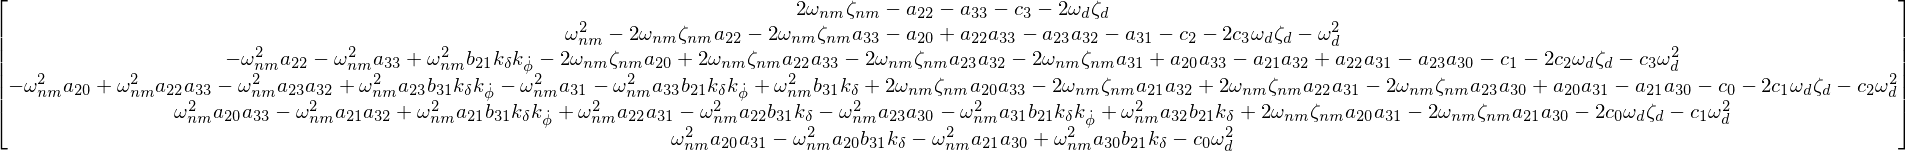

In [12]:
zero = Matrix((char_eq - desired_six_order).coeffs())
zero

The following loads in the numerical parameters for the benchmark bicycle traveling at 5 m/s, for futher use.

In [13]:
A_benchmark, B_benchmark = bicycle.benchmark_state_space(*bicycle.benchmark_matrices(), 5.0, 9.81)

In [14]:
A_benchmark, B_benchmark

(array([[  0.        ,   0.        ,   1.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ],
        [  9.48977445, -22.85146663,  -0.52761225,  -1.65257699],
        [ 11.71947687, -18.38412373,  18.38402617, -15.42432764]]),
 array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.01593498, -0.12409203],
        [-0.12409203,  4.32384018]]))

Create a dictionary that can be used to substitute the numerical values for the benchmark bicycle.

In [15]:
par = {k: v for k, v in zip(b['A'], A_benchmark.flatten()) if isinstance(k, Symbol)}
par[omega] = 30
par[zeta] = 0.707
par[omega_d] = 10.5
par[zeta_d] = 0.15
par[b['B'][2, 1]] = B_benchmark[2, 1]
par[b['B'][3, 1]] = B_benchmark[3, 1]
par

The following shows the form of the six equations that must be solved to find the gains and the other coefficients. The equations are linear in the $c$ coefficients and nonlinear in the gains. Notice that the gains are only in the last four equations.

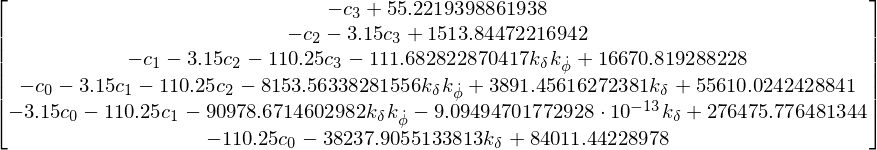

In [16]:
zero.subs(par)

Now we can attempt to solve for the gains analytically. This set of equations are polynomials in the unknowns and may have an analytical solution. First we solve the first two linear equations for $c_2$ and $c_3$ and substitute them into the last four equations.

A variable can be substituted for $k_\delta k_\dot{\phi}$ and the equations become linear.

In [17]:
sol = solve(zero, c0, c1, c2, c3, k_delta, k_delta * k_phi_dot) 

In [18]:
sol[k_phi_dot] = (sol[k_delta * k_phi_dot] / sol[k_delta])

In [19]:
sol[k_delta].subs(par)

In [20]:
sol[k_phi_dot].subs(par)

# Generate a Python function

Next I generate an efficient Python function that evaluates the found expressions for $k_\delta$ and $k_\dot{\phi}$.

In [21]:
py_func_template = '''\
def compute_inner_gains(A, B, _omega__nm_, _zeta__nm_, omega_d=10.5, zeta_d=0.15):
    """Returns the steer and roll rate gains given the state and input
    matrices of the bicycle and the neuromuscular block's natural
    frequency and damping ratio.

    Parameters
    ==========
    A : array_like, shape(4, 4)
        The state matrix for a linear Whipple bicycle model, where
        the states are [roll angle, steer angle, roll angular rate,
        steer angular rate].
    B : array_like, shape(4, 2)
        The input matrix for a linear Whipple bicycle model, where
        the inputs are [roll torque, steer torque].
    omega_nm : float
        The natural frequency of the neuromuscular model.
    zeta_nm : float
        The damping ratio of the neuromuscular model.
    omega_d : float, optional
        The natural frequency of the desired closed loop pole.
    zeta_d : float, optional
        The damping ratio of the desired closed loop pole.

    Returns
    =======
    k_delta : float
        The steer angle feedback gain.
    k_phi_dot : float
        The roll rate feedback gain.

    """
    {matrix_expansion}

    {sub_exprs}

{main_exprs}

    return k_delta, k_phi_dot\
'''

In [22]:
sub_exprs, main_exprs = cse([sol[k_delta], sol[k_phi_dot]])

In [23]:
zero_syms = zero.free_symbols
matrix_expansion = []
for mat in ['A', 'B']:
    for i, row in enumerate(b[mat].tolist()):
        for j, col in enumerate(row):
            if col in zero_syms:
                matrix_expansion.append('{} = {}[{}, {}]'.format(col, mat, i, j))

In [24]:
from sympy.printing.lambdarepr import lambdarepr

In [25]:
sub_exprs_txt = ['{} = {}'.format(x, lambdarepr(y)) for x, y in sub_exprs]

In [26]:
main_exprs_txt = '    k_delta = {}\n\n    k_phi_dot = {}'.format(*[lambdarepr(m) for m in main_exprs])

The full function is shown below:

In [27]:
func_txt = py_func_template.format(matrix_expansion='\n    '.join(matrix_expansion),
                              sub_exprs='\n    '.join(sub_exprs_txt),
                              main_exprs=main_exprs_txt)
print(func_txt)

def compute_inner_gains(A, B, _omega__nm_, _zeta__nm_, omega_d=10.5, zeta_d=0.15):
    """Returns the steer and roll rate gains given the state and input
    matrices of the bicycle and the neuromuscular block's natural
    frequency and damping ratio.

    Parameters
    A : array_like, shape(4, 4)
        The state matrix for a linear Whipple bicycle model, where
        the states are [roll angle, steer angle, roll angular rate,
        steer angular rate].
    B : array_like, shape(4, 2)
        The input matrix for a linear Whipple bicycle model, where
        the inputs are [roll torque, steer torque].
    omega_nm : float
        The natural frequency of the neuromuscular model.
    zeta_nm : float
        The damping ratio of the neuromuscular model.
    omega_d : float, optional
        The natural frequency of the desired closed loop pole.
    zeta_d : float, optional
        The damping ratio of the desired closed loop pole.

    Returns
    k_delta : float
        The steer

In [28]:
with open('../src/generated_functions.py', 'w') as f:
    f.write(func_txt)

# Generate a Matlab function

In [29]:
m_func_template = '''\
function [k_delta, k_phi_dot] = compute_inner_gains(A, B, omega_nm, zeta_nm, omega_d, zeta_d)
% Returns the steer and roll rate gains given the state and input
% matrices of the bicycle and the neuromuscular block's natural
% frequency and damping ratio.
%
%   Parameters
%   ==========
%
%   A : double, shape(4, 4)
%       The state matrix for a linear Whipple bicycle model, where
%       the states are [roll angle, steer angle, roll angular rate,
%       steer angular rate].
%   B : double, shape(4, 2)
%       The input matrix for a linear Whipple bicycle model, where
%       the inputs are [roll torque, steer torque].
%   omega_nm : double
%       The natural frequency of the neuromuscular model.
%   zeta_nm : double
%       The damping ratio of the neuromuscular model.
%   omega_d : double, shape(1, 1)
%       The natural frequency of the desired closed loop pole.
%   zeta_d : double, shape(1, )
%       The damping ratio of the desired closed loop pole.
%
%   Returns
%   =======
%   k_delta : float
%       The steer angle feedback gain.
%   k_phi_dot : float
%       The roll rate feedback gain.

    {matrix_expansion}

    {sub_exprs}

{main_exprs}

'''

In [30]:
from sympy import octave_code

In [31]:
sub_exprs_txt = [octave_code(y, assign_to=x) for x, y in sub_exprs]

In [32]:
main_exprs_txt = [octave_code(expr, assign_to=var)
                  for var, expr in zip(['k_delta', 'k_phi_dot'], main_exprs)]

In [33]:
matrix_expansion_matlab = []
for mat in ['A', 'B']:
    for i, row in enumerate(b[mat].tolist()):
        for j, col in enumerate(row):
            if col in zero_syms:
                matrix_expansion_matlab.append('{} = {}({}, {});'.format(col, mat, i + 1, j + 1))

In [34]:
m_func_txt = m_func_template.format(matrix_expansion='\n    '.join(matrix_expansion_matlab),
                              sub_exprs='\n    '.join(sub_exprs_txt),
                              main_exprs='    ' + '\n    '.join(main_exprs_txt))
print(m_func_txt)

function [k_delta, k_phi_dot] = compute_inner_gains(A, B, omega_nm, zeta_nm, omega_d, zeta_d)
% Returns the steer and roll rate gains given the state and input
% matrices of the bicycle and the neuromuscular block's natural
% frequency and damping ratio.
%
%   Parameters
%   ==========
%
%   A : double, shape(4, 4)
%       The state matrix for a linear Whipple bicycle model, where
%       the states are [roll angle, steer angle, roll angular rate,
%       steer angular rate].
%   B : double, shape(4, 2)
%       The input matrix for a linear Whipple bicycle model, where
%       the inputs are [roll torque, steer torque].
%   omega_nm : double
%       The natural frequency of the neuromuscular model.
%   zeta_nm : double
%       The damping ratio of the neuromuscular model.
%   omega_d : double, shape(1, 1)
%       The natural frequency of the desired closed loop pole.
%   zeta_d : double, shape(1, )
%       The damping ratio of the desired closed loop pole.
%
%   Returns
%   =======
%  

In [35]:
with open('../src/compute_inner_gains.m', 'w') as f:
    f.write(m_func_txt)

# Check the results

Here, I make use of the function to calculate the gains to see if it gives reasonable answers. First, see what kind of results are returned for the benchmark bicycle traveling at 5 m/s.

In [36]:
exec(func_txt)

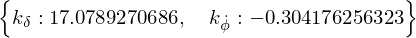

In [37]:
k_delta_sol, k_phi_dot_sol = compute_inner_gains(A_benchmark, B_benchmark, 30, 0.707)
gain_sol = {k_delta: k_delta_sol, k_phi_dot: k_phi_dot_sol}
gain_sol

This is a good sign. The roll rate gain is found to be a small negative number and the steer rate gain is larger and positive. But the values that we find for our paper are more like $k_\delta=45, k_\dot{\phi}=-0.08$ for the regular bicycles traveling at 5.0 m/s. But this more closely aligns with what I did in my dissertation (http://moorepants.github.io/dissertation/control.html#model-description). There I found that you could get the same closed loop results for the two loops and have some flexibility in choice of gains. In the case of the description in my dissertation I get very similar numbers as this. In fact I can check to see if I get the same values as in my dissertation.

In [38]:
real_bike = bp.Bicycle('Rigidcl', pathToData='/home/moorepants/src/BicycleParameters/data/')

We have foundeth a directory named: /home/moorepants/src/BicycleParameters/data/bicycles/Rigidcl.
Found the RawData directory: /home/moorepants/src/BicycleParameters/data/bicycles/Rigidcl/RawData
Recalcuting the parameters.
The glory of the Rigidcl parameters are upon you!


/home/moorepants/src/BicycleParameters/bicycleparameters/com.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cartesian(arrays[1:], out=out[0:m,1:])
/home/moorepants/src/BicycleParameters/bicycleparameters/com.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out[j*m:(j+1)*m,1:] = out[0:m,1:]


In [39]:
real_bike.add_rider('Charlie')

There is no rider on the bicycle, now adding Charlie.
No parameter files found, calculating the human configuration.


In [40]:
A_real_bike, B_real_bike = real_bike.state_space(5.0, nominal=True)

In [41]:
A_real_bike

array([[  0.        ,   0.        ,   1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ],
       [  8.27673976, -19.24025703,  -0.15126742,  -1.27363532],
       [ 19.96881539, -18.88653895,   8.74213104, -18.14135119]])

In [42]:
B_real_bike

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.00965478, -0.09603994],
       [-0.09603994,  5.55039373]])

In [43]:
compute_inner_gains(A_real_bike, B_real_bike, 30, 0.707)

Very nice! In my dissertation I found 17.5 and -0.44, so this does the same thing as my method. But it doesn't quite give the exact same results as what Ron's method gives in the paper. So we will need to investigate further.

Lastly, let's just check to see if this puts the poles where we wanted them to go:

In [44]:
eq = char_eq.subs(par).subs(gain_sol).as_poly(s)

In [45]:
eq.nroots()

In [46]:
desired_second_order.subs(par).as_poly(s).nroots()

The closed loop poles are exactly where they should be.

In [47]:
!conda list

# packages in environment at /home/moorepants/miniconda3/envs/bmd2016:
#
Using Anaconda Cloud api site https://api.anaconda.org
cairo                     1.12.18                       6  
uncertainties             2.4.8                    py35_0    conda-forge
cycler                    0.10.0                   py35_0  
decorator                 4.0.10                   py35_0  
dill                      0.2.5                    py35_0  
entrypoints               0.2.2                    py35_0  
fontconfig                2.11.1                        6  
freetype                  2.5.5                         1  
glib                      2.43.0                        1  
harfbuzz                  0.9.39                        1  
ipykernel                 4.3.1                    py35_0  
ipython                   5.0.0                    py35_0  
ipython-notebook          4.0.4                    py35_0  
ipython_genutils          0.1.0                    py35_0  
jinja2             